In [1]:
import torch
import numpy as np
import os
import pandas as pd
from google.colab import drive

In [2]:
drive.mount('/content/drive/')

Mounted at /content/drive/


In [3]:
if torch.cuda.is_available():
    device = torch.device("cuda")
    print('Available GPU:', torch.cuda.get_device_name(0))
else:
    print('No GPU available, using the CPU')
    device = torch.device("cpu")

Available GPU: Tesla T4


In [4]:
df = pd.read_csv("/content/drive/MyDrive/Глубокое обучение/6/data/labeled_rutoxic.csv", delimiter=',', header=0, names=['sentence', 'label'])

print('В наборе предложений: {:,}\n'.format(df.shape[0]))

В наборе предложений: 14,412



In [8]:
# Пример
df.sample(10)

,sentence,label
10741,"скажите, а как белка срет в квартире. Если ее ...",0.0
9632,Я знал что подобный комент будет....\n,1.0
9167,"Не все они плохие. А орган зайти типо рне, как...",1.0
2668,Сратый петух с вырвиглазными превьюхами и 256 ...,1.0
11111,"Надо что-то делать, надо что-то делать, надо ч...",0.0
1084,"После маски,лицо жмет",0.0
11000,У нас в отделе принято каждые полтора часа про...,0.0
13000,"глянула посты, целенаправленное освещение как ...",0.0
7602,А следующая лекция Религия и положительные тен...,0.0
6547,"Да вот тоже думаем, что пора. У нас машина ест...",0.0


In [5]:
# Нас интересуют метки классов и сами предложения, на них мы будем обучать нашу сеть
sentences = df.sentence.values
labels = df.label.values

In [6]:
from transformers import BertTokenizer

tokenizer = BertTokenizer('/content/drive/MyDrive/Глубокое обучение/6/data/vocab_rutoxic.txt', do_lower_case=True, do_basic_tokenize=True, never_split=None)

tokenizer.vocab_size

100792

In [7]:
sl = [len(tokenizer.convert_tokens_to_ids(tokenizer.tokenize(sen))) for sen in sentences]
print('Максимальная длина предложения: ', max([len(tokenizer.convert_tokens_to_ids(tokenizer.tokenize(sen))) for sen in sentences]))

# посмотрим сколько предложений имеет длину более 64 символа
value_c = pd.Series(sl).value_counts()
print('Предложений длиннее 64 токена: ', sum(value_c[64:]))

# довольно много, но придется ими пожертвовать
# будем их обрезать

input_ids = np.zeros((len(sentences),64))

Максимальная длина предложения:  1627
Предложений длиннее 64 токена:  2005


In [8]:
for s,i in zip(sentences,range(len(sentences))):
    enc_s = tokenizer.encode(s,
                        add_special_tokens = True, # У казываем, что нам нужно добавить служебные токены
                        padding = 'max_length',  # дополнение до макс.длины
                        max_length = 64,         # максимальная длина предложений
                        truncation = True        # все что длиннее max_length будет обрезаться
                   )
    # Формируем список id токенов
    input_ids[i,]=enc_s


# Создаем attention mask для виртуальных токенов
attention_masks = []

for s in input_ids:
    #   Если ID = 0, это виртуальный токен и маска для него 0.
    #   Если ID > 0, это реальный токен и маска для него 1.
    att_mask = [int(id_ > 0) for id_ in s]
    attention_masks.append(att_mask)

In [9]:
from sklearn.model_selection import train_test_split

# разбиваем данные, метки классов
train_inputs, validation_inputs, train_labels, validation_labels = train_test_split(input_ids, labels, test_size=0.1)
# и маску
train_masks, validation_masks, _, _ = train_test_split(attention_masks, labels, test_size=0.1)

# все конвертируем в тензоры
train_inputs = torch.tensor(train_inputs)
validation_inputs = torch.tensor(validation_inputs)

train_labels = torch.tensor(train_labels)
validation_labels = torch.tensor(validation_labels)

train_masks = torch.tensor(train_masks)
validation_masks = torch.tensor(validation_masks)

In [10]:
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler

# размер батча придется уменьшить (если на GPU), т.к. за счет
# увеличившегося словаря выросла и модель
batch_size = 4

# Пакуем в тренировочный предложения (ID), маску и метки классов
train_data = TensorDataset(train_inputs, train_masks, train_labels)
train_sampler = RandomSampler(train_data)
train_dataloader = DataLoader(train_data, sampler=train_sampler, batch_size=batch_size)

# и в валидационный
validation_data = TensorDataset(validation_inputs, validation_masks, validation_labels)
validation_sampler = SequentialSampler(validation_data)
validation_dataloader = DataLoader(validation_data, sampler=validation_sampler, batch_size=batch_size)

In [11]:
from transformers import BertForSequenceClassification, AdamW, PreTrainedModel, BertConfig

# Загрузка теперь делается через конфигурационный файл, в котором изменен размер словаря
configuration = BertConfig.from_pretrained('/content/drive/MyDrive/Глубокое обучение/6/data/config_rutoxic.json')
model = BertForSequenceClassification(configuration)

# Отправляем модель на GPU
if torch.cuda.is_available():
    model.cuda()

# Задаем оптимизатор
optimizer = AdamW(model.parameters(),
                  lr = 2e-5, # скорость обучения
                  eps = 1e-8 # специфический параметр, повышающий стабильность обучения
                )

from transformers import get_linear_schedule_with_warmup

# Количество эпох обучения
epochs = 4

# Шагов обучения = number of batches * number of epochs.
total_steps = len(train_dataloader) * epochs

# scheduler - планировщик изменяющий скорость обучения
scheduler = get_linear_schedule_with_warmup(optimizer, num_warmup_steps = 0, num_training_steps = total_steps)

/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:591: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


In [12]:
def flat_accuracy(preds, labels):
    pred_flat = np.argmax(preds, axis=1).flatten()
    labels_flat = labels.flatten()
    return np.sum(pred_flat == labels_flat) / len(labels_flat)


import time
import datetime
import random

# Задаем seed
seed_val = 42
random.seed(seed_val)
np.random.seed(seed_val)
torch.manual_seed(seed_val)
torch.cuda.manual_seed_all(seed_val)

# Тут храним наши лоссы
loss_values = []

# Цикл обучения будет состоять из обучения и валидации
for epoch_i in range(0, epochs):

    ################ Часть обучения #####################

    print("")
    print('Эпоха {:} из {:} '.format(epoch_i + 1, epochs))

    t0 = time.time()

    # потери за эпоху
    total_loss = 0

    # переключаем в режим обучения
    model.train()

    # пробегаем по батчам
    for step, batch in enumerate(train_dataloader):


        # Достаем из батча данные: предложения, маску и метки
        b_input_ids = batch[0].to(device)
        b_input_mask = batch[1].to(device)
        b_labels = batch[2].to(device)

        # обнуляем градиенты
        model.zero_grad()

        # прямой проход
        outputs = model(b_input_ids.to(torch.long),
                    token_type_ids=None,
                    attention_mask=b_input_mask.to(torch.long),
                    labels=b_labels.to(torch.long))

               # потери
        loss = outputs.loss
        total_loss += loss.item()

        # обратный проход
        loss.backward()

        # обрезаем градиенты до 1.0, чтобы предотвратить "взрыв градиентов"
        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)

        # обновляем параметры модели
        optimizer.step()

        # изменяем скорость обучения
        scheduler.step()

         # диагностическую информацию выводим каждые 100 батчей
        if step % 10 == 0 and not step == 0:
            time_elapsed = time.strftime("%H:%M:%S", time.gmtime(time.time() - t0))
            print(' Батч {:>4,} из {:>4,}. Затраченное время: {:}. Ошибка: {:}.'.format(step, len(train_dataloader), time_elapsed, loss))


    # средний loss
    avg_train_loss = total_loss / len(train_dataloader)

    # сохраним для графика
    loss_values.append(avg_train_loss)

    print("")
    print(" Средний loss: {0:.2f}".format(avg_train_loss))
    print(" Обучение эпохи прошло за: {:}".format(time.strftime("%H:%M:%S", time.gmtime(time.time() - t0))))

    ################ Часть валидации #####################
    # Позволяет понять правильно ли мы учимся и учимся ли вообще

    print("\n Validation...")
    t0 = time.time()

    # модель в  evaluation режим
    model.eval()

    # диагностические переменные
    eval_loss, eval_accuracy = 0, 0
    nb_eval_steps, nb_eval_examples = 0, 0

    # пробегаем валидационный набор
    for batch in validation_dataloader:

        batch = tuple(t.to(device) for t in batch)

        # берем нужные данные из батча
        b_input_ids, b_input_mask, b_labels = batch

        with torch.no_grad():
            # прямой проход
            outputs = model(b_input_ids.to(torch.long),
                    token_type_ids=None,
                    attention_mask=b_input_mask.to(torch.long),
                    labels=b_labels.to(torch.long))

        # "logits" хранят вероятности классов похоже на softmax
        logits = outputs.logits

        logits = logits.detach().cpu().numpy()
        label_ids = b_labels.to('cpu').numpy()

        # считаем точность модели на валидации
        tmp_eval_accuracy = flat_accuracy(logits, label_ids)

        # суммарная точность
        eval_accuracy += tmp_eval_accuracy

        # сколько батчей прошло
        nb_eval_steps += 1

    # результат валидации
    print("  Accuracy: {0:.2f}".format(eval_accuracy/nb_eval_steps))
    print("  Валидация прошла за: {:}".format(time.strftime("%H:%M:%S", time.gmtime(time.time() - t0))))


Эпоха 1 из 4 
 Батч   10 из 3,243. Затраченное время: 00:00:02. Ошибка: 0.7468757629394531.
 Батч   20 из 3,243. Затраченное время: 00:00:03. Ошибка: 0.9202014207839966.
 Батч   30 из 3,243. Затраченное время: 00:00:04. Ошибка: 1.0279784202575684.
 Батч   40 из 3,243. Затраченное время: 00:00:05. Ошибка: 0.3514006733894348.
 Батч   50 из 3,243. Затраченное время: 00:00:06. Ошибка: 0.8459874391555786.
 Батч   60 из 3,243. Затраченное время: 00:00:07. Ошибка: 0.6960789561271667.
 Батч   70 из 3,243. Затраченное время: 00:00:08. Ошибка: 0.8786178827285767.
 Батч   80 из 3,243. Затраченное время: 00:00:09. Ошибка: 0.5394326448440552.
 Батч   90 из 3,243. Затраченное время: 00:00:10. Ошибка: 0.6213024854660034.
 Батч  100 из 3,243. Затраченное время: 00:00:11. Ошибка: 0.8064193725585938.
 Батч  110 из 3,243. Затраченное время: 00:00:12. Ошибка: 0.6393645405769348.
 Батч  120 из 3,243. Затраченное время: 00:00:12. Ошибка: 0.588890016078949.
 Батч  130 из 3,243. Затраченное время: 00:00:13. 

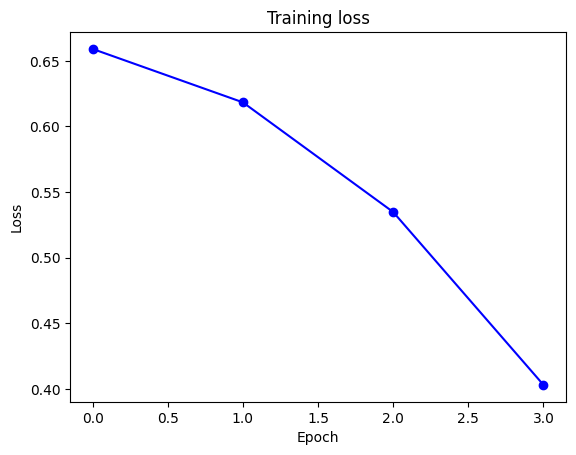

[1]


<ipython-input-15-61623ccd4688>:31: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at ../torch/csrc/utils/tensor_new.cpp:278.)
  batch = tuple(t.to(device) for t in torch.Tensor([input_ids, attention_mask]))


In [15]:
import matplotlib.pyplot as plt

plt.plot(loss_values, 'b-o')
plt.title("Training loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.show()


# Загрузим предобученную модель
model.to(device)


# Проверим как оно работает
sentence = 'Почитайте посты у этого автора,может найдете что нибудь полезное.'
sentence = 'Ну, посмотрел я комментарии к твоим постам, процент говнокомментов ниже средней отметки.'
enc_s = tokenizer.encode(sentence,
                        add_special_tokens = True, # У казываем, что нам нужно добавить служебные токены
                        padding = 'max_length',  # дополнение до макс.длины
                        max_length = 64,         # максимальная длина предложений
                        truncation = True        # все что длиннее max_length будет обрезаться
                   )

# Формируем список id токенов
input_ids = np.array(enc_s)

# Создаем attention mask для виртуальных токенов
attention_mask = [int(id_ > 0) for id_ in input_ids]

model.eval()
batch = tuple(t.to(device) for t in torch.Tensor([input_ids, attention_mask]))
b_input_ids, b_input_mask = batch
with torch.no_grad():
    outputs = model( b_input_ids.unsqueeze(0).to(torch.long), token_type_ids=None, attention_mask=b_input_mask.unsqueeze(0))

logits = outputs.logits
logits = logits.detach().cpu().numpy()
predicted_label = np.argmax(logits, axis=1).flatten()
print(predicted_label)